<a href="https://colab.research.google.com/github/talpt/pyton/blob/main/Maestro_Murrey_CrossOver_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-rxxn52du
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-rxxn52du
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl size=17533 sha256=a6a65b9b8a078a3d1fb056be4c662f82f1d3d2f8d5acbde41705aee9bcbb7b35
  Stored in directory: /tmp/pip-ephem-wheel-cache-jworagoz/wheels/0a/ba/99/b27476fd1e4caf0dd70445cdc6798195d3b90005a1501a12f7
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173912 sha256=fe0c7e32ded44047d8cc227b94e2083b17075a97c7640393c9d01fb55b65b639
  Stored in directory: /root/.cache/pip/wheels/2c/56/19/bf7ee5e164aa99a976e3f64841c83b5a

Zaman Dilimi Seçin:
1. 15 Dakika
2. 30 Dakika
3. 45 Dakika
4. 1 Saat
5. 2 Saat
6. 4 Saat
7. Günlük
8. Haftalık
9. Aylık
Seçiminiz (1-9): 7


ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


Error fetching data for BRYAT: 'NoneType' object has no attribute 'empty'
+----+-------------+---------------------+-------------+---------------------------------+
|    | Hisse Adı   | Tarih               |   Son Fiyat | Geçilen Seviye                  |
+====+=============+=====================+=============+=================================+
|  0 | A1CAP       | 2025-01-15 06:00:00 |    25.06    | -1/8 Aşırı Satım                |
+----+-------------+---------------------+-------------+---------------------------------+
|  1 | AHGAZ       | 2025-01-15 06:00:00 |    20.16    | +2/8 İleri Aşırı Alım           |
+----+-------------+---------------------+-------------+---------------------------------+
|  2 | AKCNS       | 2025-01-15 06:00:00 |   181.4     | 5/8 Trade Aralığı Tepe Seviyesi |
+----+-------------+---------------------+-------------+---------------------------------+
|  3 | AKGRT       | 2025-01-15 06:00:00 |     7.42    | 3/8 Trade Aralığı Dip           |
+----+----------

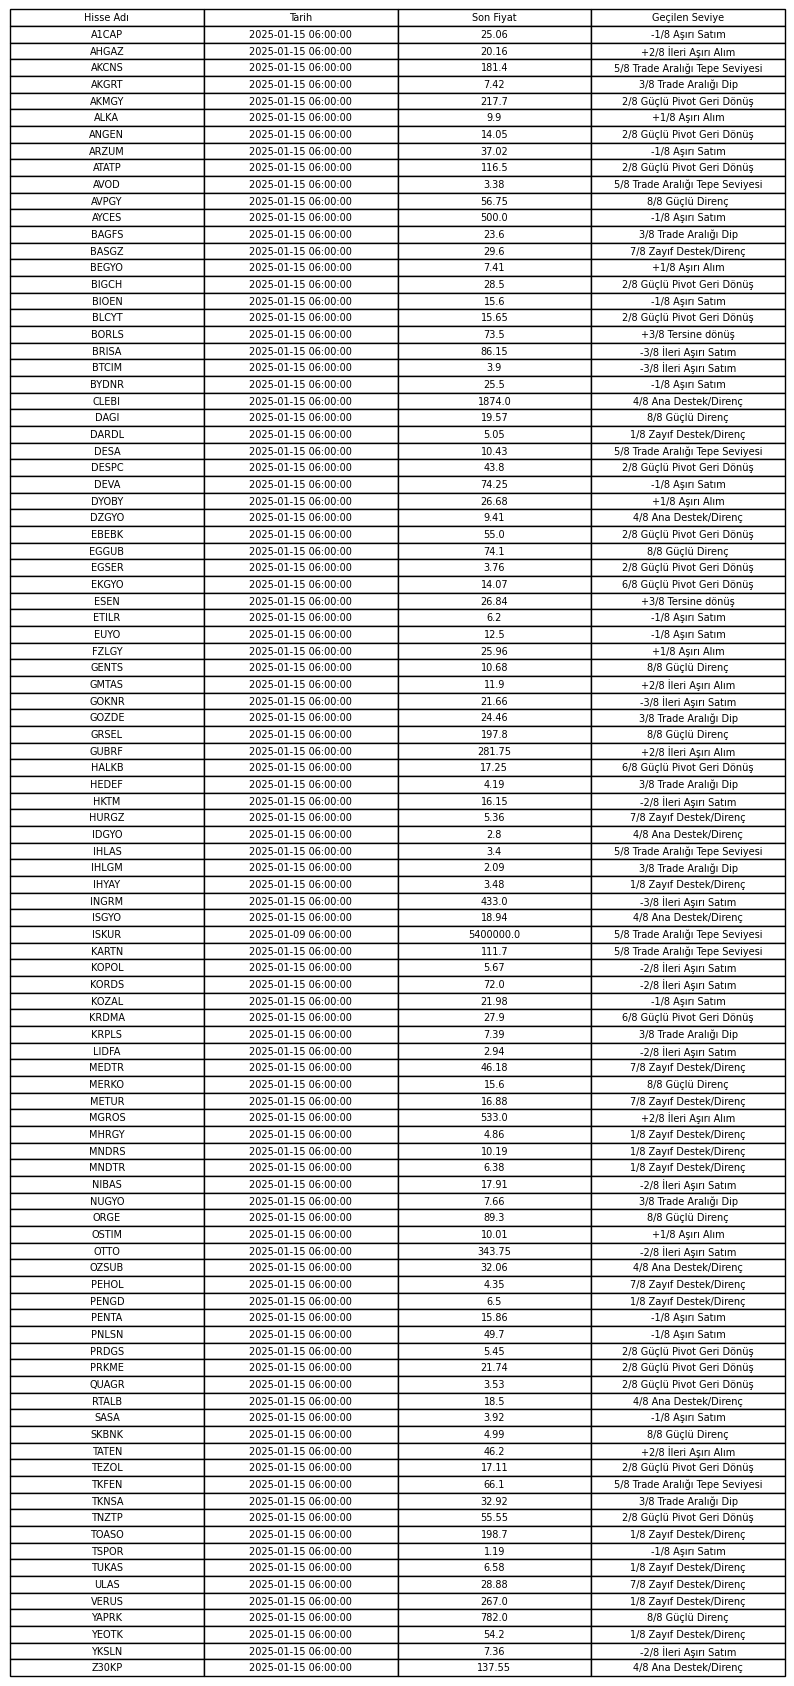

In [ ]:
!pip install git+https://github.com/rongardF/tvdatafeed backtesting openpyxl
!pip install tradingview-screener==2.5.0

import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# TradingView'den verileri çekmek için kimlik bilgileri
tv = TvDatafeed()

# Türk hisse senetlerini almak
Hisseler = get_all_symbols(market='turkey')
Hisseler = [symbol.replace('BIST:', '') for symbol in Hisseler]
Hisseler = sorted(Hisseler)

# Kullanıcının zaman dilimini seçmesini sağlayan fonksiyon
def get_interval_choice():
    intervals = {
        '1': ('15 Dakika', Interval.in_15_minute),
        '2': ('30 Dakika', Interval.in_30_minute),
        '3': ('45 Dakika', Interval.in_45_minute),
        '4': ('1 Saat', Interval.in_1_hour),
        '5': ('2 Saat', Interval.in_2_hour),
        '6': ('4 Saat', Interval.in_4_hour),
        '7': ('Günlük', Interval.in_daily),
        '8': ('Haftalık', Interval.in_weekly),
        '9': ('Aylık', Interval.in_monthly)
    }

    print("Zaman Dilimi Seçin:")
    for key, (label, _) in intervals.items():
        print(f"{key}. {label}")

    choice = input("Seçiminiz (1-9): ").strip()
    while choice not in intervals:
        print("Geçersiz seçim. Lütfen 1 ile 9 arasında bir değer girin.")
        choice = input("Seçiminiz (1-9): ").strip()

    return intervals[choice][1]  # Seçilen Interval nesnesini döndürür

# Pivot seviyelerini hesaplamak için fonksiyon
def calculate_pivot_levels(data, frame=255, mult=1.0):
    logTen = np.log(10)
    log8 = np.log(8)
    log2 = np.log(2)
    lookback = round(frame * mult)

    data['high_lookback'] = data['high'].rolling(window=lookback).max()
    data['low_lookback'] = data['low'].rolling(window=lookback).min()

    vHigh = data['high_lookback'].iloc[-1]
    vLow = data['low_lookback'].iloc[-1]
    vDist = vHigh - vLow

    tmpHigh = max(vLow, vHigh)
    tmpLow = vLow

    sfVar = np.log(0.4 * tmpHigh) / logTen - np.floor(np.log(0.4 * tmpHigh) / logTen)
    SR = np.where(tmpHigh > 25,
                  np.where(sfVar > 0,
                           np.exp(logTen * (np.floor(np.log(0.4 * tmpHigh) / logTen) + 1)),
                           np.exp(logTen * np.floor(np.log(0.4 * tmpHigh) / logTen))),
                  100 * np.exp(log8 * np.floor(np.log(0.005 * tmpHigh) / log8)))

    nVar1 = np.log(SR / (tmpHigh - tmpLow)) / log8
    nVar2 = nVar1 - np.floor(nVar1)
    N = np.where(nVar1 <= 0, 0, np.where(nVar2 == 0, np.floor(nVar1), np.floor(nVar1) + 1))

    SI = SR * np.exp(-N * log8)
    M = np.floor(1.0 / log2 * np.log((tmpHigh - tmpLow) / SI) + 0.0000001)
    I = np.round((tmpHigh + tmpLow) * 0.5 / (SI * np.exp((M - 1) * log2)))

    Bot = (I - 1) * SI * np.exp((M - 1) * log2)
    Top = (I + 1) * SI * np.exp((M - 1) * log2)

    Increment = (Top - Bot) / 8
    absTop = Top + 3 * Increment

    pivot_levels = {
        '+3/8 Tersine dönüş': absTop,
        '+2/8 İleri Aşırı Alım': absTop - Increment,
        '+1/8 Aşırı Alım': absTop - 2 * Increment,
        '8/8 Güçlü Direnç': absTop - 3 * Increment,
        '7/8 Zayıf Destek/Direnç': absTop - 4 * Increment,
        '6/8 Güçlü Pivot Geri Dönüş': absTop - 5 * Increment,
        '5/8 Trade Aralığı Tepe Seviyesi': absTop - 6 * Increment,
        '4/8 Ana Destek/Direnç': absTop - 7 * Increment,
        '3/8 Trade Aralığı Dip': absTop - 8 * Increment,
        '2/8 Güçlü Pivot Geri Dönüş': absTop - 9 * Increment,
        '1/8 Zayıf Destek/Direnç': absTop - 10 * Increment,
        '-1/8 Aşırı Satım': absTop - 11 * Increment,
        '-2/8 İleri Aşırı Satım': absTop - 12 * Increment,
        '-3/8 İleri Aşırı Satım': absTop - 13 * Increment
    }

    return pivot_levels

# Sadece crossover durumlarını kontrol eden fonksiyon
def check_crossover(symbols, exchange, interval, n_bars):
    reports = []

    for symbol in symbols:
        try:
            data = tv.get_hist(symbol, exchange, interval=interval, n_bars=n_bars)
            if data.empty:
                print(f"No data found for {symbol}.")
                continue

            data.reset_index(inplace=True)
            pivot_levels = calculate_pivot_levels(data)

            current_price = data.iloc[-1]['close']
            previous_price = data.iloc[-2]['close']
            crossover_status = False
            crossed_level = ""

            for level_name, level_value in pivot_levels.items():
                if (previous_price < level_value and current_price >= level_value) or \
                   (previous_price > level_value and current_price <= level_value):
                    crossover_status = True
                    crossed_level = level_name
                    break

            if crossover_status:
                reports.append([symbol, data.iloc[-1]['datetime'], current_price, crossed_level])

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    return pd.DataFrame(reports, columns=['Hisse Adı', 'Tarih', 'Son Fiyat', 'Geçilen Seviye'])

# Kullanıcıdan zaman dilimi seçimi
selected_interval = get_interval_choice()

# Taramayı gerçekleştirme
n_bars = 255  # Gereken çubuk sayısı
crossover_report = check_crossover(Hisseler, 'BIST', selected_interval, n_bars)

# Sonuçları gösterme ve kaydetme
if crossover_report.empty:
    print("Anlık crossover durumu bulunan hiçbir hisse senedi yok.")
else:
    print(tabulate(crossover_report, headers='keys', tablefmt='grid'))

    # Excel dosyasına kaydetme
    crossover_report.to_excel('crossover_raporu.xlsx', index=False)
    print("Sonuçlar 'crossover_raporu.xlsx' dosyasına kaydedildi.")

    # Görselleştirme
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=crossover_report.values, colLabels=crossover_report.columns, cellLoc='center', loc='center')
    plt.show()
